# **3. Advanced lecture: 베이지안 최적화 실습**


---


By Mingyu Lee and Ikjin Lee

http://idol.kaist.ac.kr/

mglee91@kaist.ac.kr

https://scholar.google.co.kr/citations?hl=ko&user=yDYefB8AAAAJ&view_op=list_works&sortby=pubdate

https://github.com/MingyuLee91

IDOL Lab at KAIST


---

### **< Source papers >**

* **Lee, M.**, Jung, Y., Choi, J., & **Lee, I.** (2022). A reanalysis-based multi-fidelity (RBMF) surrogate framework for efficient structural optimization. Computers & Structures, 273, 106895.
* Lee, J., Park, D., **Lee, M.**, Lee, H., Park, K., **Lee, I.**, & Ryu, S. (2023). Machine learning-based inverse design methods considering data characteristics and design space size in materials design and manufacturing: a review. Materials Horizons.
* **Lee, M.**, Noh, Y., & **Lee, I.** (2024). A novel sampling method for adaptive gradient-enhanced Kriging. Computer Methods in Applied Mechanics and Engineering, 418, 116456.
* Lee, J., **Lee, M.**, Lee, B. J., & **Lee, I.** (2024). A comprehensive multi-fidelity surrogate framework based on Gaussian process for datasets with heterogeneous responses. Knowledge-Based Systems, 295, 111827.
* **Lee, M.**, Jung, Y., Hwang, C., Kim, M., Kim, M., Lee, U., & **Lee, I.** (2024). An efficient multi-fidelity design optimization framework for a thermoelectric generator system. Energy Conversion and Management, 315, 118788.


Original source codes from https://github.com/SMTorg/SMT

Related documentation https://smt.readthedocs.io/en/latest/#

Modified version by Mingyu Lee

---


### **< Contents >**

 1) Optimization example

 2) One-dimensional example (Kriging model)

 **3) One-dimensional example (Bayesian optimization)**

 4) Engineering application (Surrogate-based optimization)

## **▣ 대리 (예측) 모델을 어떻게 업데이트할 것인가?**

* 만들어진 대리 모델을 기반으로, 유망한 데이터를 순차적으로 추가하여 대리 모델을 업데이트
* Bayesian 접근법은 기존의 사전 정보와 새로운 데이터를 결합해 사후 정보를 갱신하는 통계적 접근 방식
* Bayesian optimization (BO)는 사전 정보를 활용해 함수의 최적값을 효율적으로 찾는 기법
* Efficient Global Optimization (EGO)은 고비용 함수의 최적점을 찾기 위해 Gaussian process model과 Acquisition function를 활용하는 기법
* 특히, 대리 모델을 업데이트할 때, 목적에 맞는 Acquisition function을 선택하는 것이 중요


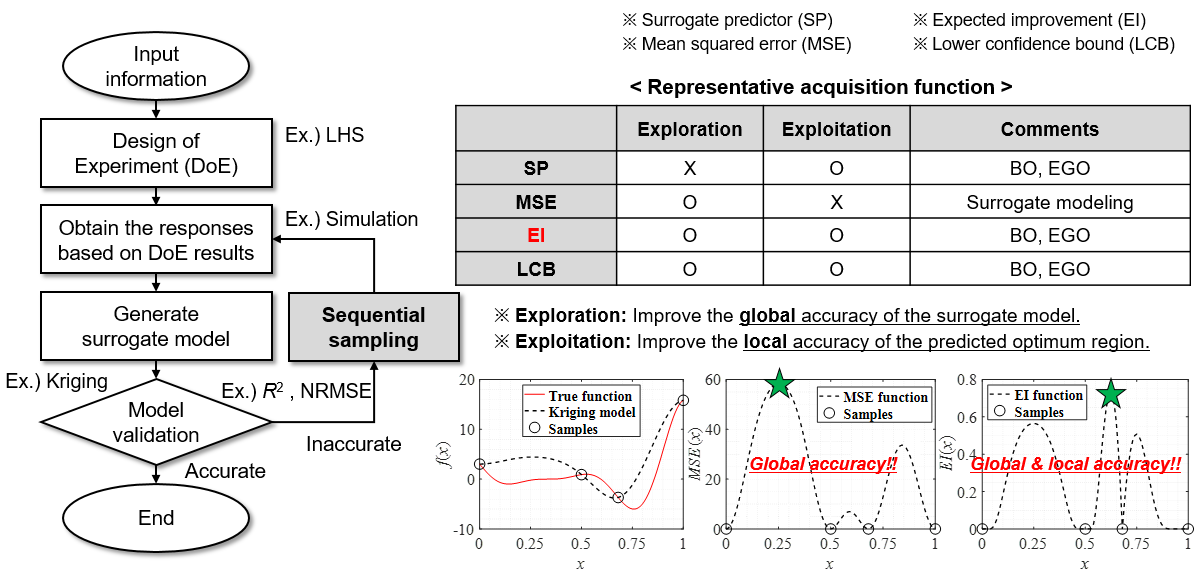

* **Expected improvement (EI) function**
<br/>▷ 확률 기반 대리 모델 (e.g., Kriging)을 이용하여 최적해를 효율적으로 찾기 위해 사용하는 Acquisition function
<br/>▷ 대리 모델의 평균 예측 값 ($\hat{y}$(**x**))과 불확실성 정보 ($\hat{s}$(**x**))로 구성된 함수

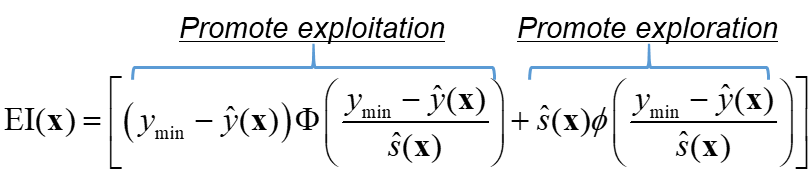

In [122]:
!pip install smt

### ※ **예제 & 응용 문제**
* 설계 공간: 0~1
* 근사하고자 하는 실제 함수: y = (6x - 2)<sup>2</sup> sin(12x - 4)
* 데이터 (Case 1): x = 0, 0.5, 0.69, 1.0에서 입력 및 출력 값 존재
* 데이터 (Case 2): x = 0, 0.4, 0.6, 1.0에서 입력 및 출력 값 존재
* 데이터 (Case 3): x = 0, 0.2, 1.0에서 입력 및 출력 값 존재
* Kriging으로 대리모델링을 수행
* 다양한 Acquisition 함수를 사용하여 최적해 찾기 (SP, MSE, EI, LCB)
* 데이터를 최대 10개 사용
* True 최적해: x<sub>opt</sub> = 0.75724875, y<sub>opt</sub> = -6.02074006


In [123]:
import numpy as np
from smt.applications import EGO
from smt.surrogate_models import KRG
from smt.utils.design_space import DesignSpace
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize, differential_evolution

In [124]:
# Acquisition function 선택 (대리모델 업데이트)
# Criterion = "SP" # Surrogate predictor
# Criterion = "MSE" # Mean-squared error
Criterion = "EI" # Expected improvement
# Criterion = "LCB" # Lower confidence bound

In [125]:
# 실험계획법 (DOE)
xt = np.array([[0.0], [0.5], [0.69], [1.0]])  # 입력 데이터 (2D 배열)
# xt = np.array([[0.0], [0.4], [0.6], [1.0]])  # 입력 데이터 (2D 배열)
# xt = np.array([[0.0], [0.2], [1.0]])  # 입력 데이터 (2D 배열)

# 데이터 생성 (시뮬레이션 or 실험)
def HF_function(x):  # high-fidelity function
    return ((6 * x - 2) ** 2) * np.sin((6 * x - 2) * 2)

yt = HF_function(xt)
y_min_array = np.min(yt)

# 대리모델링
initial_theta = np.array([1e-2])  # 초기 하이퍼파라미터 설정
sm = KRG(theta0=initial_theta, print_global=False)
sm.set_training_values(xt, yt)  # 하이퍼파라미터 최적화
sm.train()  # 하이퍼파라미터 최적화

In [126]:
##########################################################################################################
# Acquisition function 정의 (Surrogate predictor)
def SP_function(x, sm):

    # Predict the mean and variance at point x
    y_pred = sm.predict_values(x) # 예측값 (평균)

    return y_pred[0]

##########################################################################################################
# Acquisition function 정의 (Mean-squared error)
def MSE_function(x, sm):

    # Predict the mean and variance at point x
    y_s2 = sm.predict_variances(x) # 불확실 정보 (분산)

    return y_s2[0]

##########################################################################################################
# Acquisition function 정의 (Expected improvement)
def EI_function(x, sm, yt):
    y_min = np.min(yt) # 샘플링된 출력값 중에 최소값
    # Predict the mean and variance at point x
    y_pred = sm.predict_values(x) # 예측값 (평균)
    y_s2 = sm.predict_variances(x) # 불확실 정보 (분산)

    # Avoid division by zero
    y_s = np.sqrt(y_s2) # 표준편차
    y_s = np.maximum(y_s, 1e-16) # 수치 문제 해결을 위한 trick

    # EI calculation
    EI_value = (y_min - y_pred)*norm.cdf((y_min - y_pred)/y_s) + y_s * norm.pdf((y_min - y_pred)/y_s)

    return EI_value[0]

##########################################################################################################
# Acquisition function 정의 (Lower-confidence bound)
def LCB_function(x, sm):

    # Predict the mean and variance at point x
    y_pred = sm.predict_values(x) # 예측값 (평균)
    y_s2 = sm.predict_variances(x) # 불확실 정보 (분산)
    y_s = np.sqrt(y_s2) # 표준편차

    # LCB calculation
    A = 1; # User-defined parameter (Generally, 1~4)
    LCB_value = y_pred - A*y_s

    return LCB_value[0]

##########################################################################################################

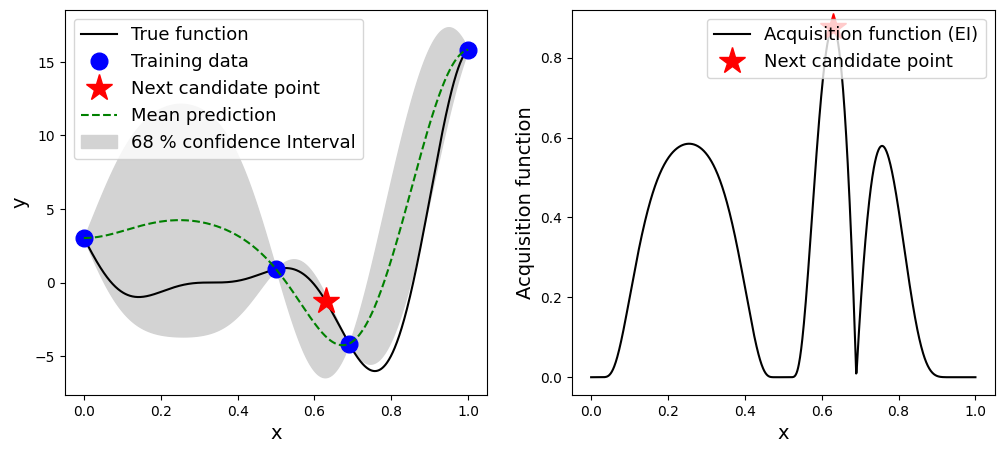

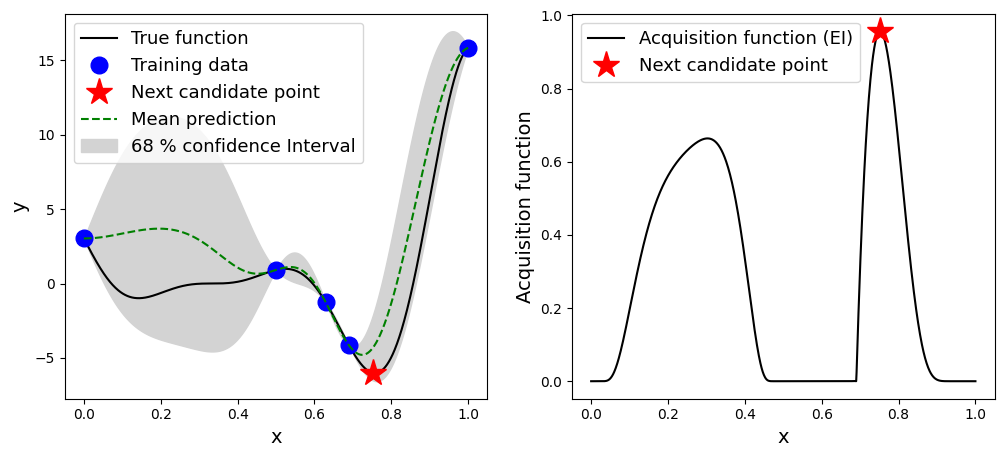

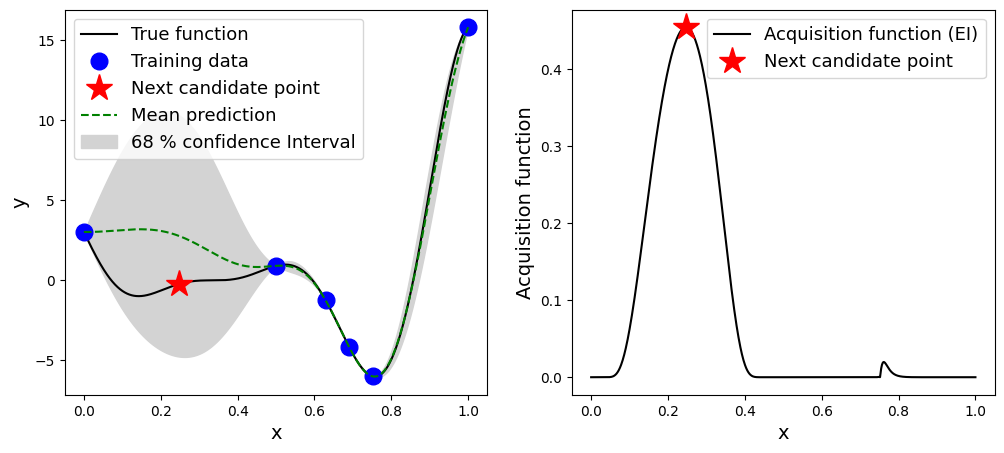

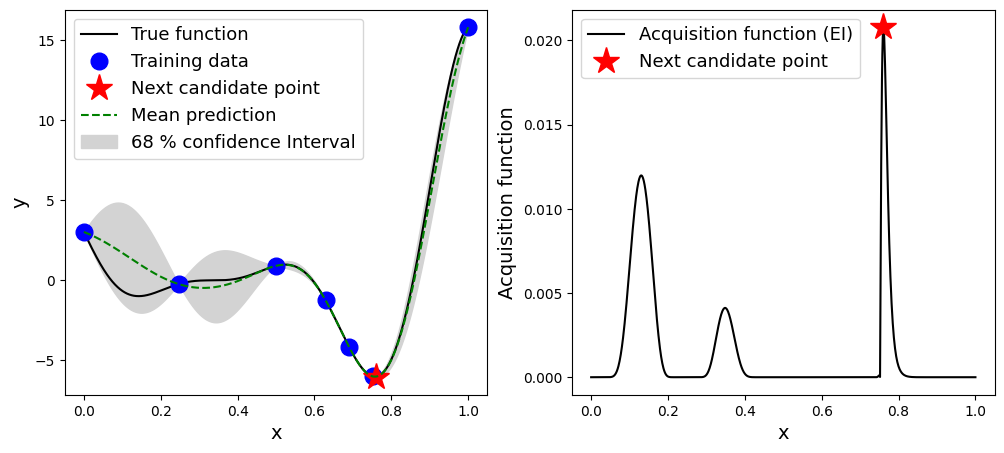

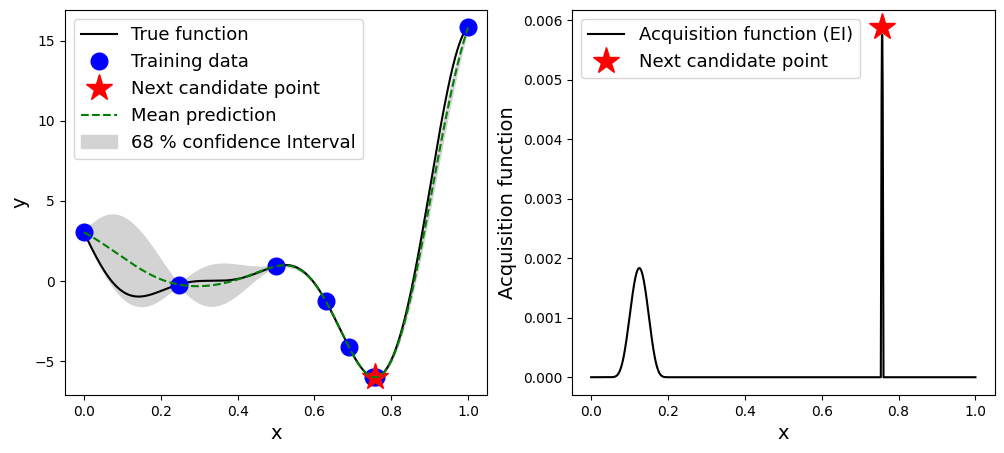

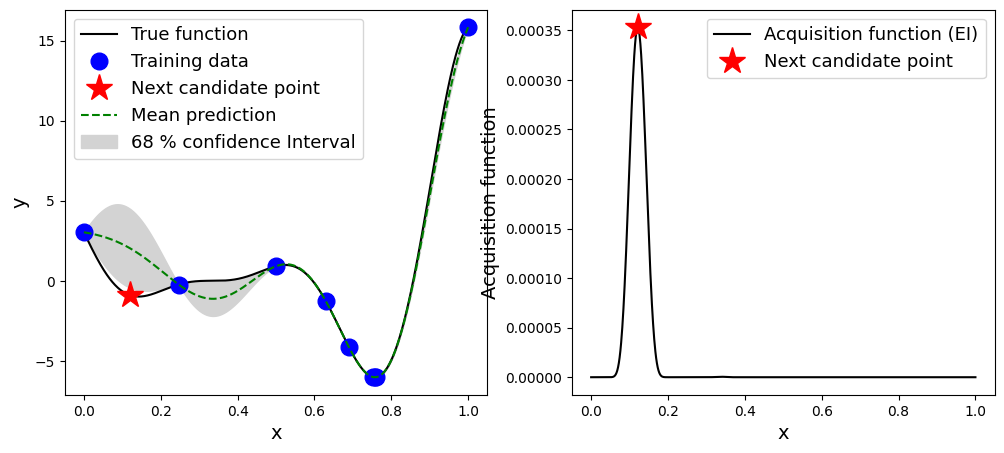

In [127]:
# Iterative process
n_iterations = 10-xt.shape[0] # 추가시킬 샘플의 개수

for iteration in range(n_iterations):

    # Acquisition function에 대한 최적화 수행
    if Criterion == "SP":
        result = differential_evolution(lambda x: SP_function(x, sm), bounds=[(0, 1)], popsize=200)  # Minimizing the SP function

    elif Criterion == "MSE":
        result = differential_evolution(lambda x: -MSE_function(x, sm), bounds=[(0, 1)], popsize=200)  # Maximizing the MSE function

    elif Criterion == "EI":
        result = differential_evolution(lambda x: -EI_function(x, sm, yt), bounds=[(0, 1)], popsize=200)  # Maximizing the EI function

    elif Criterion == "LCB":
        result = differential_evolution(lambda x: LCB_function(x, sm), bounds=[(0, 1)], popsize=200)  # Minimizing the LCB function


    x_opt = result.x.reshape(-1, 1)  # x_opt를 2D 배열로 변환

    ##################################################### - Skip part - #####################################################
    # 시각화 (Post-processing)
    num = 1000
    x = np.linspace(0.0, 1.0, num).reshape(-1, 1)  # 0에서 1까지 등간격으로 num개의 x값을 생성

    # 결과 배열 초기화
    y_true = np.zeros_like(x)
    y_mean = np.zeros_like(x)
    s2 = np.zeros_like(x)
    acquisition_plot = np.zeros_like(x)

    # 각 x에 대해 계산
    for i in range(len(x)):
        x_input = np.array([x[i]])  # x[i]를 2D 배열로 변환
        y_true[i] = HF_function(x_input)
        y_mean[i] = sm.predict_values(x_input)  # 예측값
        s2[i] = sm.predict_variances(x_input)  # 불확실 정보
        # Acquisition function
        if Criterion == "SP":
            acquisition_plot[i] = SP_function(x_input, sm)
        elif Criterion == "MSE":
            acquisition_plot[i] = MSE_function(x_input, sm)
        elif Criterion == "EI":
            acquisition_plot[i] = EI_function(x_input, sm, yt)
        elif Criterion == "LCB":
            acquisition_plot[i] = LCB_function(x_input, sm)

    # 그림 그리기
    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

    # figure 왼쪽
    axs[0].plot(x, y_true, "k")  # 실제함수
    axs[0].plot(xt, yt, "bo", markersize=12)
    axs[0].plot(x_opt, HF_function(x_opt).reshape(-1, 1), "r*", markersize=20)
    axs[0].plot(x, y_mean, "g--")
    axs[0].fill_between(
        np.ravel(x),
        np.ravel(y_mean - 1 * np.sqrt(s2)),  # -1 시그마
        np.ravel(y_mean + 1 * np.sqrt(s2)),  # +1 시그마
        color="lightgrey",
    )

    axs[0].set_xlabel("x", fontsize='14')
    axs[0].set_ylabel("y", fontsize='14')
    axs[0].legend(
        ["True function", "Training data", "Next candidate point", "Mean prediction", "68 % confidence Interval"],
        loc="best",
        fontsize=13,
    )

    # figure 오른쪽
    axs[1].plot(x, acquisition_plot, "k")  # Acquisition function
    # 알고리즘을 통해 구한 최적해
    if Criterion == "SP":
        axs[1].plot(x_opt, SP_function(x_opt, sm),"r*", markersize = 20)
    elif Criterion == "MSE":
        axs[1].plot(x_opt, MSE_function(x_opt, sm),"r*", markersize = 20)
    elif Criterion == "EI":
        axs[1].plot(x_opt, EI_function(x_opt, sm, yt),"r*", markersize = 20)
    elif Criterion == "LCB":
        axs[1].plot(x_opt, LCB_function(x_opt, sm),"r*", markersize = 20)


    axs[1].set_xlabel("x", fontsize='14')
    axs[1].set_ylabel("Acquisition function", fontsize='14')
    axs[1].legend(
        [f"Acquisition function ({Criterion})", "Next candidate point"],
        loc="best",
        fontsize=13,
    )

    plt.show()
    ##################################################### - Skip part - #####################################################

    f_opt = HF_function(x_opt).reshape(-1, 1) # 실제 black-box model에서 output이 계산 되는 스텝 (FEA, CFD, Experiment)

    # 새로운 샘플 추가
    xt = np.vstack((xt, x_opt)) # input data 업데이트
    yt = np.vstack((yt, f_opt)) # output data 업데이트
    y_min_array = np.vstack((y_min_array, np.min(yt)))

    sm = KRG(theta0=initial_theta, print_global=False)
    sm.set_training_values(xt, yt)  # 누적된 샘플로 대리모델 학습
    sm.train()  # 하이퍼파라미터 최적화


Text(0, 0.5, 'Function value')

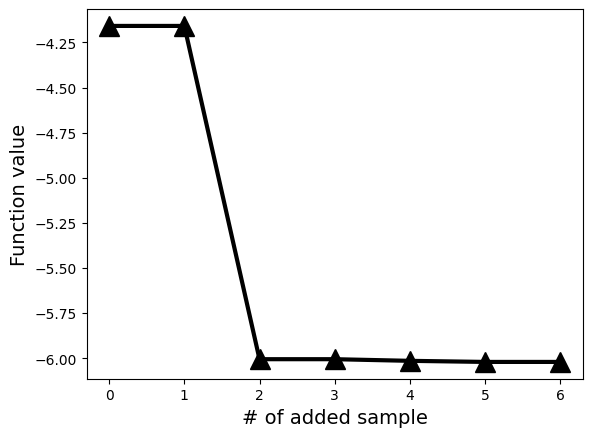

In [128]:
fig, axs = plt.subplots(1)
axs.plot(y_min_array,"k^-", markersize=14,linewidth=3) # History
axs.set_xlabel("# of added sample",fontsize="14")
axs.set_ylabel("Function value",fontsize="14")

In [129]:
min_index = np.argmin(yt)
x_min_so_far = xt[min_index]
y_min_so_far = np.min(yt)

In [130]:
print("Optimal input so far",x_min_so_far)
print("Optimal output so far",y_min_so_far)
print("True optimal input",0.75724875)
print("True optimal output",-6.02074006)

Optimal input so far [0.75726043]
Optimal output so far -6.020739982974673
True optimal input 0.75724875
True optimal output -6.02074006
